In [45]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
# from networkx import nx
# %matplotlib inline


In [2]:
# set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [46]:
# recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev
tau_s = 5 * ms              # synaptic time constant

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N_network = 1000                     # number of neurons

# simulation params
sim_time_ms = 10 * 60 * 60                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100   # timestep for monitor evaluation

# model
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
'''

G = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

synapses = Synapses(G, G,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre / (N_network*p)
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost / (N_network*p)
                        w = clip(w + Apre, 0, wMax)''')
           
# connect synapses
#synapses.connect(condition='i!=j', p=p)
# erg = nx.erdos_renyi_graph(N_network, p, directed=True)#use erdos renyi random graph to determine synapse connections
num_synapses = 0
# for i in range(0, erg.number_of_nodes()):
#     nbs = [n for n in erg.neighbors(i)]
#     synapses.connect(i=[i], j=nbs) #connect neuron i to appropriate neighbors indicated in the erdos renyi graph
#     num_synapses += len(nbs)
for i in range(N_network):
    for j in range(N_network):
        if i != j:
            if np.random.rand() < p:
                synapses.connect(i=i, j=j)
                num_synapses += 1

# get connection density (for use in STDP params)
p0 = p #compute_p0(G, synapses)
# print(p0)

# stdp params
wMax = 5 * uamp * cm**-2   # max syn weight
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
# dApost = -wMax / 5 / N              # f neg (f post)
# dApre = -dApost * tauPost / tauPre  # f pos (f pre)
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax
dApre *= wMax

# assign synaptic weights
# mu_w0 = wMax / 3
# sigma_w0 = wMax / 20
# synapses.w = 'mu_w0 + (0.5 - rand()) * sigma_w0'
synapses.w = "rand() * wMax * 2 / (p0 * N_network)"

# monitors
#v_mon = StateMonitor(G, 'v', record=True)
sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(synapses, 'w', record=range(num_synapses), dt=monitor_dt_ms * ms)
# record=True, dt=monitor_dt_ms * ms)

# initial voltage values
for i in range(0, N_network):
    G[i].v = (np.random.normal(0, 1)*(vTh-vR)) #initial membrane potential for each neuron in neuron group

#
# run simulation
#
run(sim_time_ms * ms, report='text')

# plots
#plot_v(v_mon, sp_mon_exc, 0, True)
#plot_spike_trains(sp_mon_exc)


Starting simulation at t=0. s for a duration of 36. s
3.6634 (10%) simulated in 10s, estimated 1m 28s remaining.
7.3711 (20%) simulated in 20s, estimated 1m 18s remaining.
11.0679 (30%) simulated in 30s, estimated 1m 8s remaining.
14.783800000000001 (41%) simulated in 40s, estimated 57s remaining.
18.5064 (51%) simulated in 50s, estimated 47s remaining.
22.241 (61%) simulated in 1m 0s, estimated 37s remaining.
25.950200000000002 (72%) simulated in 1m 10s, estimated 27s remaining.
29.6433 (82%) simulated in 1m 20s, estimated 17s remaining.
33.3718 (92%) simulated in 1m 30s, estimated 7s remaining.
36.0 (100%) simulated in 1m 37s


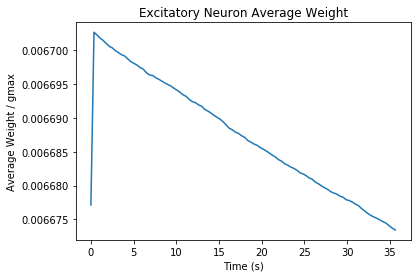

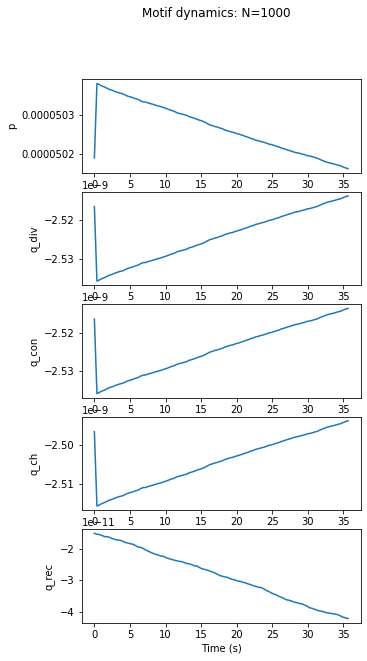

In [47]:
# more plots
plot_avg_syn_weight(w_mon, wMax)

# figure 7
plot_motif_dynamics(w_mon, synapses, N_network, False)

In [ ]:
plot_spike_trains(sp_mon_exc)


In [71]:
from networkx import nx
prefs.codegen.target = 'numpy'
start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev
tau_s = 5 * ms              # synaptic time constant

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N_network = 1000                     # number of neurons

# simulation params
sim_time_ms = 100 * 60 * 60                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100   # timestep for monitor evaluation

# model
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
'''

G = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

synapses = Synapses(G, G,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre / (N_network*p)
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost / (N_network*p)
                        w = clip(w + Apre, 0, wMax)''')
           
# connect synapses
synapses.connect(condition='i!=j', p=p)
#erg = nx.erdos_renyi_graph(N_network, p, directed=True)#use erdos renyi random graph to determine synapse connections
num_synapses = len(synapses)



'''
num_synapses = 0
for i in range(0, erg.number_of_nodes()):
    nbs = [n for n in erg.neighbors(i)]
    synapses.connect(i=[i], j=nbs) #connect neuron i to appropriate neighbors indicated in the erdos renyi graph
    num_synapses += len(nbs)

for i in range(N_network):
    for j in range(N_network):
        if i != j:
            if np.random.rand() < p:
                synapses.connect(i=i, j=j)
                num_synapses += 1
'''

# get connection density (for use in STDP params)
p0 = p #compute_p0(G, synapses)
# print(p0)

# stdp params
wMax = 5 * uamp * cm**-2   # max syn weight
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
# dApost = -wMax / 5 / N              # f neg (f post)
# dApre = -dApost * tauPost / tauPre  # f pos (f pre)
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax
dApre *= wMax

# assign synaptic weights
mu_w0 = wMax  / (p0 * N_network)
#sigma_w0 = mu_w0 / 10
#synapses.w = "mu_w0 + (0.5 - rand()) * sigma_w0"
synapses.w = mu_w0*0.15

#synapses.w = "rand() * wMax * 2 / (p0 * N_network * 10)"

# monitors
#v_mon = StateMonitor(G, 'v', record=True)
sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(synapses, 'w', record=range(num_synapses), dt=monitor_dt_ms * ms)
# record=True, dt=monitor_dt_ms * ms)

# initial voltage values
for i in range(0, N_network):
    G[i].v = (np.random.normal(0, 1)*(vTh-vR)) #initial membrane potential for each neuron in neuron group

#
# run simulation
#
run(sim_time_ms * ms, report='text')

# plots
#plot_v(w_mon, np.arange(0,sim_time_ms, monitor_dt_ms), 0)
#plot_spike_trains(sp_mon_exc)


Starting simulation at t=0. s for a duration of 0.36 ks
3.7455000000000003 (1%) simulated in 10s, estimated 15m 51s remaining.
7.693 (2%) simulated in 20s, estimated 15m 16s remaining.
11.822999999999999 (3%) simulated in 30s, estimated 14m 43s remaining.
15.9573 (4%) simulated in 40s, estimated 14m 22s remaining.
20.040100000000002 (5%) simulated in 50s, estimated 14m 8s remaining.
24.149900000000002 (6%) simulated in 1m 0s, estimated 13m 54s remaining.
28.2393 (7%) simulated in 1m 10s, estimated 13m 42s remaining.
32.3641 (8%) simulated in 1m 20s, estimated 13m 30s remaining.
36.3223 (10%) simulated in 1m 30s, estimated 13m 22s remaining.
40.064800000000005 (11%) simulated in 1m 40s, estimated 13m 19s remaining.
43.936 (12%) simulated in 1m 50s, estimated 13m 11s remaining.
48.0405 (13%) simulated in 2m 0s, estimated 12m 59s remaining.
51.9948 (14%) simulated in 2m 10s, estimated 12m 50s remaining.
55.8247 (15%) simulated in 2m 20s, estimated 12m 43s remaining.
59.574400000000004 (16

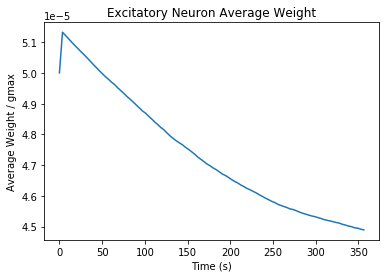

In [72]:
avg_w_e = w_mon.w.mean(axis=0)
plot(w_mon.t/second, avg_w_e)
title('Excitatory Neuron Average Weight')
xlabel('Time (s)')
ylabel('Average Weight / gmax')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

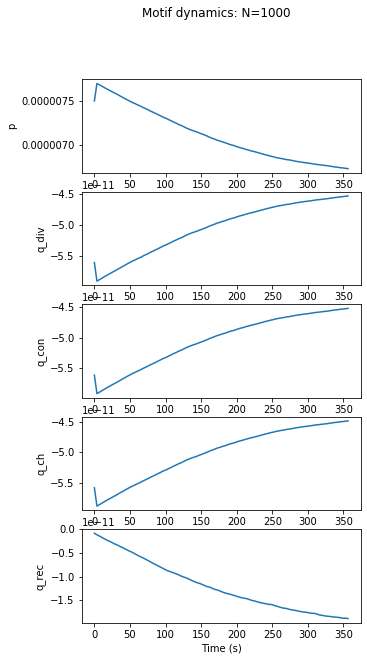

In [73]:
# figure 7
plot_motif_dynamics(w_mon, synapses, N_network, False)

100